# Исследование первого набора дексрипторов (efficientnet-b7)

Импорт базовых библиотек:

In [1]:
# ! pip install cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.nvidia.com
# ! pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com
# ! pip install cugraph-cu11 --extra-index-url=https://pypi.nvidia.com
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 28, in <module>
    if ('K80' not in gpu_name):
TypeError: a bytes-like object is required, not 'str'


In [2]:
import cupy as cp
import cudf
import pandas as pd
import numpy as np
import cupy as cp
import cudf
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from collections import Counter

import warnings

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

import plotly.io as pio
pio.renderers.default='notebook'


## 1. Знакомство со структурой данных

Прочитайте numpy-массивы из предоставленных pickle-файлов.

**Примечание** Для удобства дальнейшей работы вы можете составить четыре DataFrame с путями до изображений и соответствующими им дескрипторами.

Посмотрите на размерности каждой из четырёх заданных матриц и сравните использованные модели глубокого обучения по размерностям выходных дескрипторов изображений.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
colab_path = '/content/drive/MyDrive/SkillFactory/'
kaggle_path = '/kaggle/input/intellivision-case/'

data_path = colab_path

import pickle

desc = pd.DataFrame(pickle.load(open(
    data_path + 'IntelliVision_case/descriptors/efficientnet-b7.pickle',
    'rb'))).sample(frac=0.1)
# desc = pd.DataFrame(pickle.load(open(
#     data_path + 'IntelliVision_case/descriptors/osnet.pickle',
#     'rb'))).sample(frac=0.1)
# desc = pd.DataFrame(pickle.load(open(
#     data_path + 'IntelliVision_case/descriptors/vdc_color.pickle',
#     'rb'))).sample(frac=0.1)
# desc = pd.DataFrame(pickle.load(open(
#     data_path + 'IntelliVision_case/descriptors/vdc_type.pickle',
#     'rb'))).sample(frac=0.1)

images = cudf.DataFrame(pd.read_csv(
    data_path + 'IntelliVision_case/images_paths.csv')).iloc[desc.index]



## 2. Преобразование, очистка и анализ данных

Признаки, найденные с помощью некоторых моделей, исчисляются тысячами, что довольно много, учитывая общее количество наблюдений.

Как вы понимаете, производить кластеризацию на таком большом количестве признаков, которые были сформированы исходными моделями глубокого обучения, довольно сложно и затратно по времени. К тому же, многие признаки, найденные моделями на изображениях, могут быть сильно скоррелированы между собой.

Понизьте размерность исходных дескрипторов с помощью соответствующих методов. Можно уменьшить размерность входных данных до 100 или 200 признаков — этого будет достаточно, чтобы произвести кластеризацию, однако рекомендуем вам самостоятельно подобрать необходимое количество компонент в новом пространстве признаков.

Также позаботьтесь о масштабе признаков, воспользовавшись стандартизацией и нормализацией. После кластеризации определите, какой вариант масштабирования более успешен для каждого варианта дескрипторов.


In [5]:
from cuml.preprocessing import MinMaxScaler

normalization = MinMaxScaler()
desc = cudf.DataFrame(normalization.fit_transform(desc))

In [6]:
from cuml.decomposition import PCA

def get_principal_components(data):
  for n in range(100, 500, 25):
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(data)
    if pca.explained_variance_ratio_.sum() > 0.8:
      print('Explained variance: ', round(pca.explained_variance_ratio_.sum(), 2))
      print('Number of columns: ', principal_components.shape[1])
      return principal_components

In [7]:
desc = get_principal_components(desc)

Explained variance:  0.8
Number of columns:  475


## 3. Моделирование и оценка качества модели

### 3.1. Кластеризация изображений

После предобработки исходных данных произведите кластеризацию для каждого набора дескрипторов.

Для решения задачи используйте несколько различных методов, подобрав оптимальное количество кластеров для каждого метода и варианта дескрипторов.

В качестве метрики для подбора оптимального количества кластеров используйте внутренние меры индекс Калински — Харабаса (`calinski_harabasz_score`) и индекс Дэвиса — Болдина (`davies_bouldin_score`).

Рекомендуем вынести код для построения моделей кластеризации и подбора их параметров в отдельную функцию, чтобы не множить одинаковый код для четырёх случаев дескрипторов.

**Примечание.** Поскольку исходных данных много, могут возникнуть проблемы с оперативной памятью и скоростью работы таких алгоритмов, как K-Means. Вместо стандартного алгоритма K-Means можно воспользоваться реализацией MiniBatchKMeans.

**Примечание.** Постарайтесь написать чистый код, максимально уменьшая количество дублирующихся участков.

#### Метод DBSCAN

In [8]:
from cuml.cluster import DBSCAN

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def get_db_scales_figs(data):

    calinski_harabasz = []
    davies_bouldin = []
    silhouette = []

    min_eps = 4.5
    max_eps = 9.5
    step = 0.5
    complete = 0

    for n in np.arange(min_eps, max_eps, step):

      db = DBSCAN(
          eps=n,
          )

      db.fit_predict(data)

      calinski_harabasz.append(calinski_harabasz_score(data.to_numpy(), db.labels_.to_numpy()))
      davies_bouldin.append(davies_bouldin_score(data.to_numpy(), db.labels_.to_numpy()))
      silhouette.append(silhouette_score(data.to_numpy(), db.labels_.to_numpy()))

      complete += 1/(max_eps - min_eps)*100*step
      print('{:.2f} % completed'.format(complete))

    eps_scales = pd.DataFrame({
        'eps':np.arange(min_eps, max_eps, step),
        'silhouette_score':silhouette,
        'calinski_harabasz':calinski_harabasz,
        'davies_bouldin':davies_bouldin
    })


    fig, axes = plt.subplots(3, 1, figsize=(10,20))

    fig_sil = sns.lineplot(
            ax = axes[0],
            x = eps_scales['eps'],
            y = eps_scales['silhouette_score']
        )
    axes[0].set_title('Зависимость коэффициента силуэта от величины eps')


    fig_ch = sns.lineplot(
            ax = axes[1],
            x = eps_scales['eps'],
            y = eps_scales['calinski_harabasz']
        )
    axes[1].set_title('Зависимость индекса Калински — Харабаса от величины eps')


    fig_db = sns.lineplot(
            ax = axes[2],
            x = eps_scales['eps'],
            y = eps_scales['davies_bouldin']
        )
    axes[2].set_title('Зависимость индекса Дэвиса — Болдина от величины eps');

    fig.show()


def get_db_cluster(data, best_eps):
        db = DBSCAN(
            eps=best_eps,
#            init='random' # {‘scalable-kmeans++’, ‘k-means||’, ‘random’} or an ndarray (default = ‘scalable-k-means++’)
            )
        db.fit_predict(data)
        return db.labels_.to_numpy()

Вычислим метрики кластеризации в зависимости от величины eps:

10.00 % completed
20.00 % completed
30.00 % completed
40.00 % completed
50.00 % completed
60.00 % completed
70.00 % completed
80.00 % completed
90.00 % completed
100.00 % completed


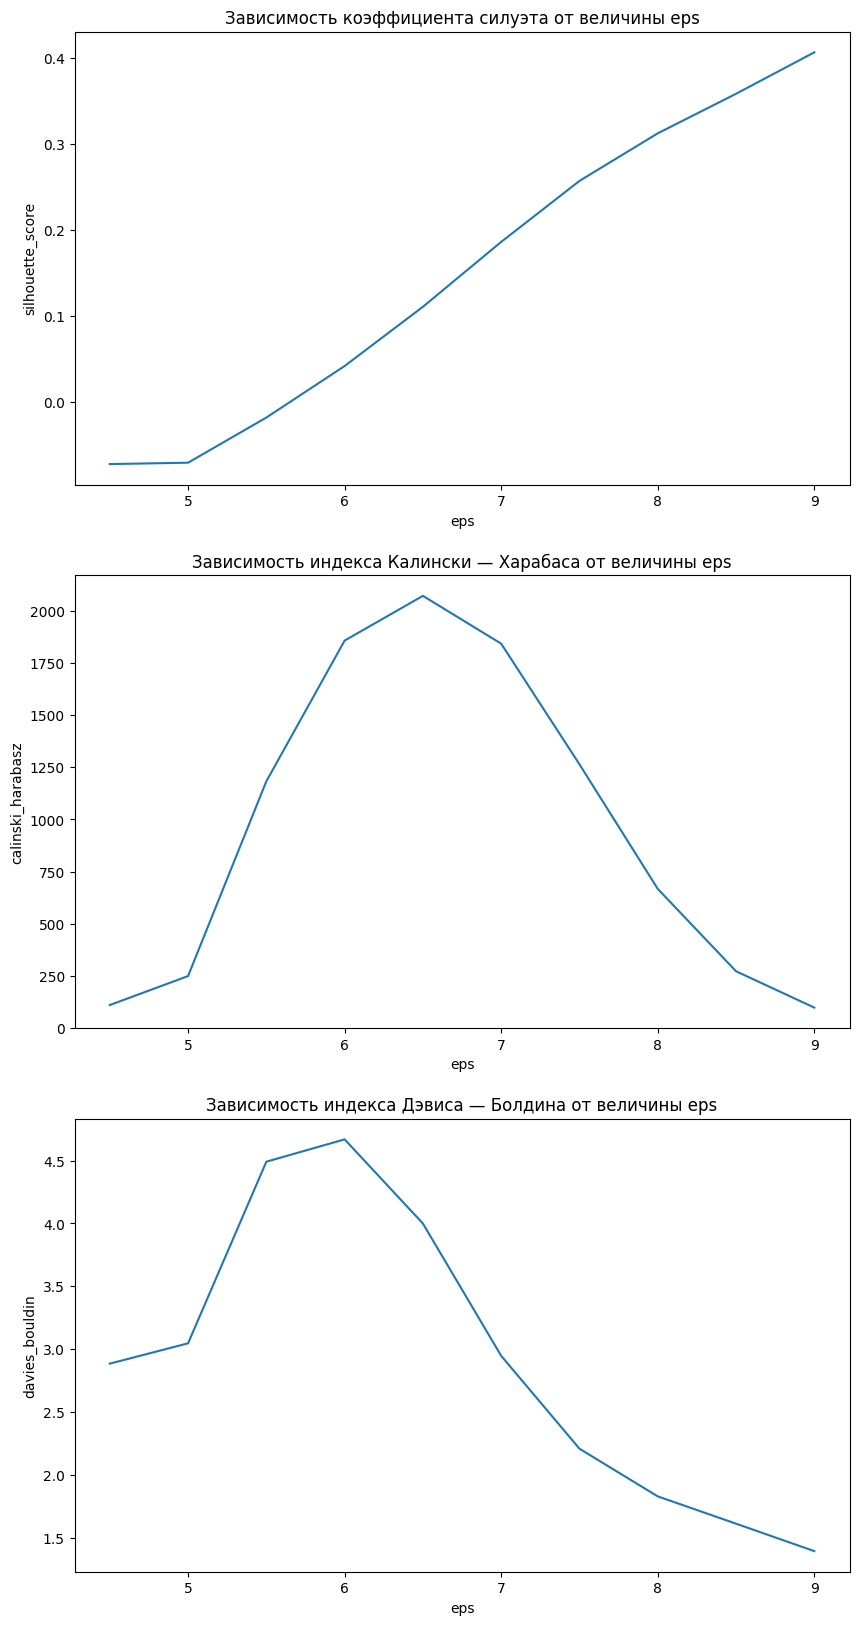

In [9]:
get_db_scales_figs(desc)

Наилучший результат наблюдается при eps = 7.

In [10]:
best_eps = 7
db_labels = get_db_cluster(desc, best_eps)

Counter(db_labels)

Counter({0: 38012, -1: 3619})

#### Метод AgglomerativeClustering

In [11]:
from cuml.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def get_agg_scales_figs(data):

    calinski_harabasz = []
    davies_bouldin = []
    silhouette = []

    min_clusters = 2
    max_clusters = 22
    complete = 0

    for n in range(min_clusters, max_clusters):

      agg = AgglomerativeClustering(
          n_clusters=n,
          )

      agg.fit_predict(data)

      calinski_harabasz.append(calinski_harabasz_score(data.to_numpy(), agg.labels_.to_numpy()))
      davies_bouldin.append(davies_bouldin_score(data.to_numpy(), agg.labels_.to_numpy()))
      silhouette.append(silhouette_score(data.to_numpy(), agg.labels_.to_numpy()))

      complete += 1/(max_clusters - min_clusters)*100
      print('{:.2f} % completed'.format(complete))

    n_clusters_scales = pd.DataFrame({
        'n_clusters':range(min_clusters,max_clusters),
        'silhouette_score':silhouette,
        'calinski_harabasz':calinski_harabasz,
        'davies_bouldin':davies_bouldin
    })


    fig, axes = plt.subplots(3, 1, figsize=(10,20))

    fig_sil = sns.lineplot(
            ax = axes[0],
            x = n_clusters_scales['n_clusters'],
            y = n_clusters_scales['silhouette_score']
        )
    axes[0].set_title('Зависимость коэффициента силуэта от количества кластеров')


    fig_ch = sns.lineplot(
            ax = axes[1],
            x = n_clusters_scales['n_clusters'],
            y = n_clusters_scales['calinski_harabasz']
        )
    axes[1].set_title('Зависимость индекса Калински — Харабаса от количества кластеров')


    fig_db = sns.lineplot(
            ax = axes[2],
            x = n_clusters_scales['n_clusters'],
            y = n_clusters_scales['davies_bouldin']
        )
    axes[2].set_title('Зависимость индекса Дэвиса — Болдина от количества кластеров');

    fig.show()

def get_agg_cluster(data, best_n):
        agg = AgglomerativeClustering(
            n_clusters=best_n,
#            init='random' # {‘scalable-kmeans++’, ‘k-means||’, ‘random’} or an ndarray (default = ‘scalable-k-means++’)
            )
        agg.fit_predict(data)
        return agg.labels_.to_numpy()

Вычислим метрики кластеризации в зависимости от количества кластеров:

5.00 % completed
10.00 % completed
15.00 % completed
20.00 % completed
25.00 % completed
30.00 % completed
35.00 % completed
40.00 % completed
45.00 % completed
50.00 % completed
55.00 % completed
60.00 % completed
65.00 % completed
70.00 % completed
75.00 % completed
80.00 % completed
85.00 % completed
90.00 % completed
95.00 % completed
100.00 % completed


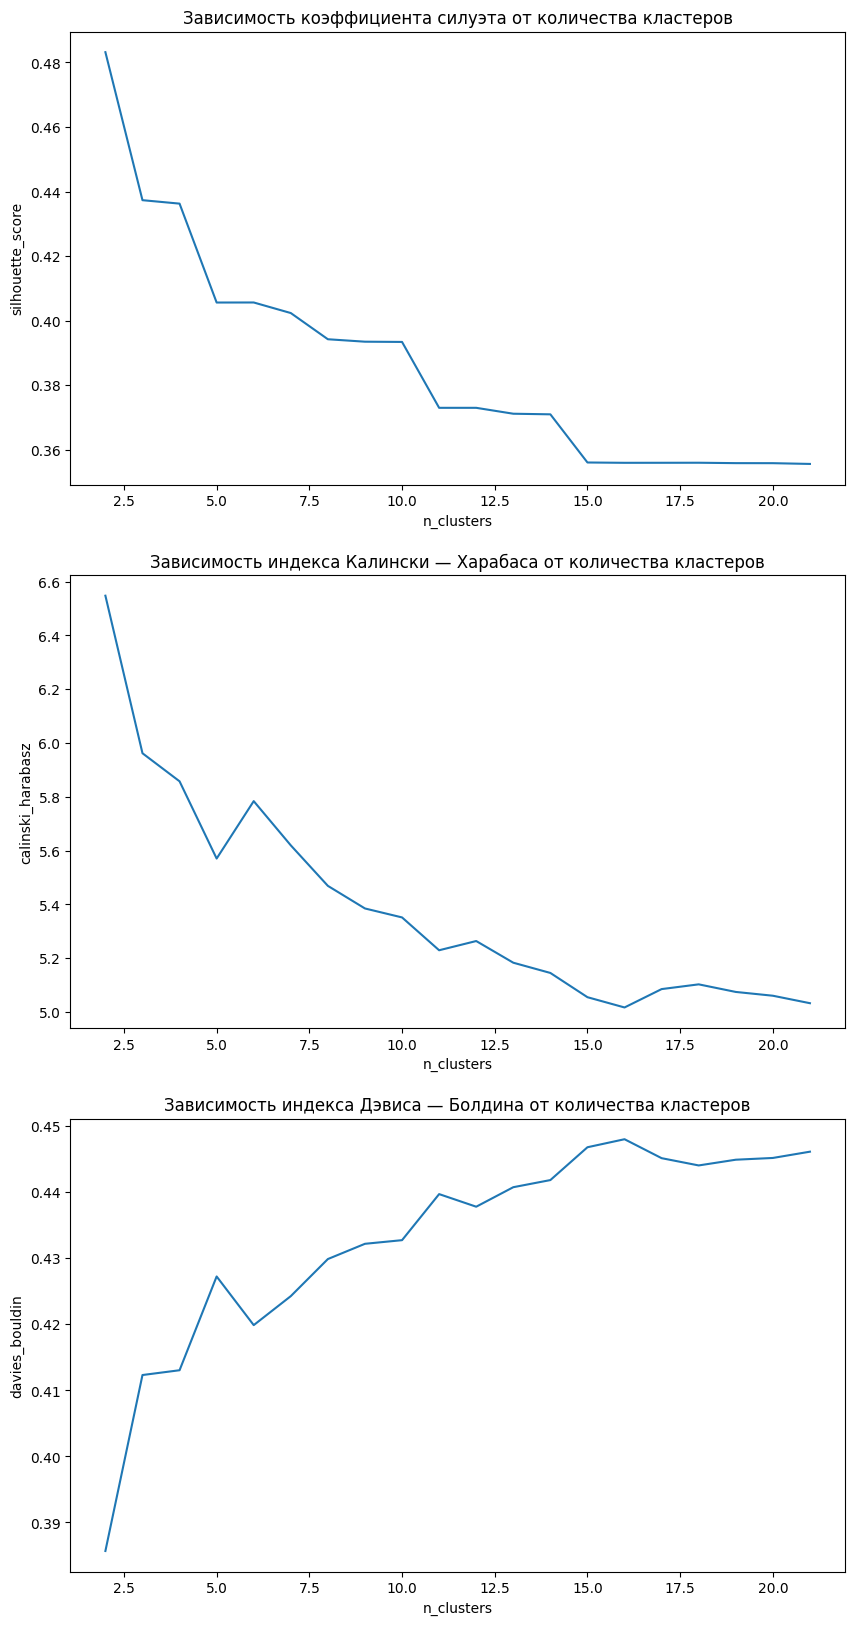

In [12]:
get_agg_scales_figs(desc)

Наилучший результат наблюдается при количестве кластеров 5.

In [13]:
best_n = 5
agg_labels = get_agg_cluster(desc, best_n)

Counter(agg_labels)

Counter({0: 41627, 4: 1, 3: 1, 2: 1, 1: 1})

#### Метод KMeans

In [15]:
from cuml.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def get_kmeans_scales_figs(data):

    calinski_harabasz = []
    davies_bouldin = []
    silhouette = []

    min_clusters = 2
    max_clusters = 22
    complete = 0

    for n in range(min_clusters, max_clusters):

      kmeans = KMeans(
          n_clusters=n,
#           algorithm='elkan'
          )

      kmeans.fit_predict(data)

      calinski_harabasz.append(calinski_harabasz_score(data.to_numpy(), kmeans.labels_.to_numpy()))
      davies_bouldin.append(davies_bouldin_score(data.to_numpy(), kmeans.labels_.to_numpy()))
      silhouette.append(silhouette_score(data.to_numpy(), kmeans.labels_.to_numpy()))

      complete += 1/(max_clusters - min_clusters)*100
      print('{:.2f} % completed'.format(complete))

    n_clusters_scales = pd.DataFrame({
        'n_clusters':range(min_clusters, max_clusters),
        'silhouette_score':silhouette,
        'calinski_harabasz':calinski_harabasz,
        'davies_bouldin':davies_bouldin
    })


    fig, axes = plt.subplots(3, 1, figsize=(10,20))

    fig_sil = sns.lineplot(
            ax = axes[0],
            x = n_clusters_scales['n_clusters'],
            y = n_clusters_scales['silhouette_score']
        )
    axes[0].set_title('Зависимость коэффициента силуэта от количества кластеров')


    fig_ch = sns.lineplot(
            ax = axes[1],
            x = n_clusters_scales['n_clusters'],
            y = n_clusters_scales['calinski_harabasz']
        )
    axes[1].set_title('Зависимость индекса Калински — Харабаса от количества кластеров')


    fig_db = sns.lineplot(
            ax = axes[2],
            x = n_clusters_scales['n_clusters'],
            y = n_clusters_scales['davies_bouldin']
        )
    axes[2].set_title('Зависимость индекса Дэвиса — Болдина от количества кластеров');

    fig.show()

def get_kmeans_cluster(data, best_n):
        kmeans = KMeans(
            n_clusters=best_n,
#            init='random' # {‘scalable-kmeans++’, ‘k-means||’, ‘random’} or an ndarray (default = ‘scalable-k-means++’)
            )
        kmeans.fit_predict(data)
        return kmeans.labels_.to_numpy()

Вычислим метрики кластеризации в зависимости от количества кластеров:

5.00 % completed
10.00 % completed
15.00 % completed
20.00 % completed
25.00 % completed
30.00 % completed
35.00 % completed
40.00 % completed
45.00 % completed
50.00 % completed
55.00 % completed
60.00 % completed
65.00 % completed
70.00 % completed
75.00 % completed
80.00 % completed
85.00 % completed
90.00 % completed
95.00 % completed
100.00 % completed


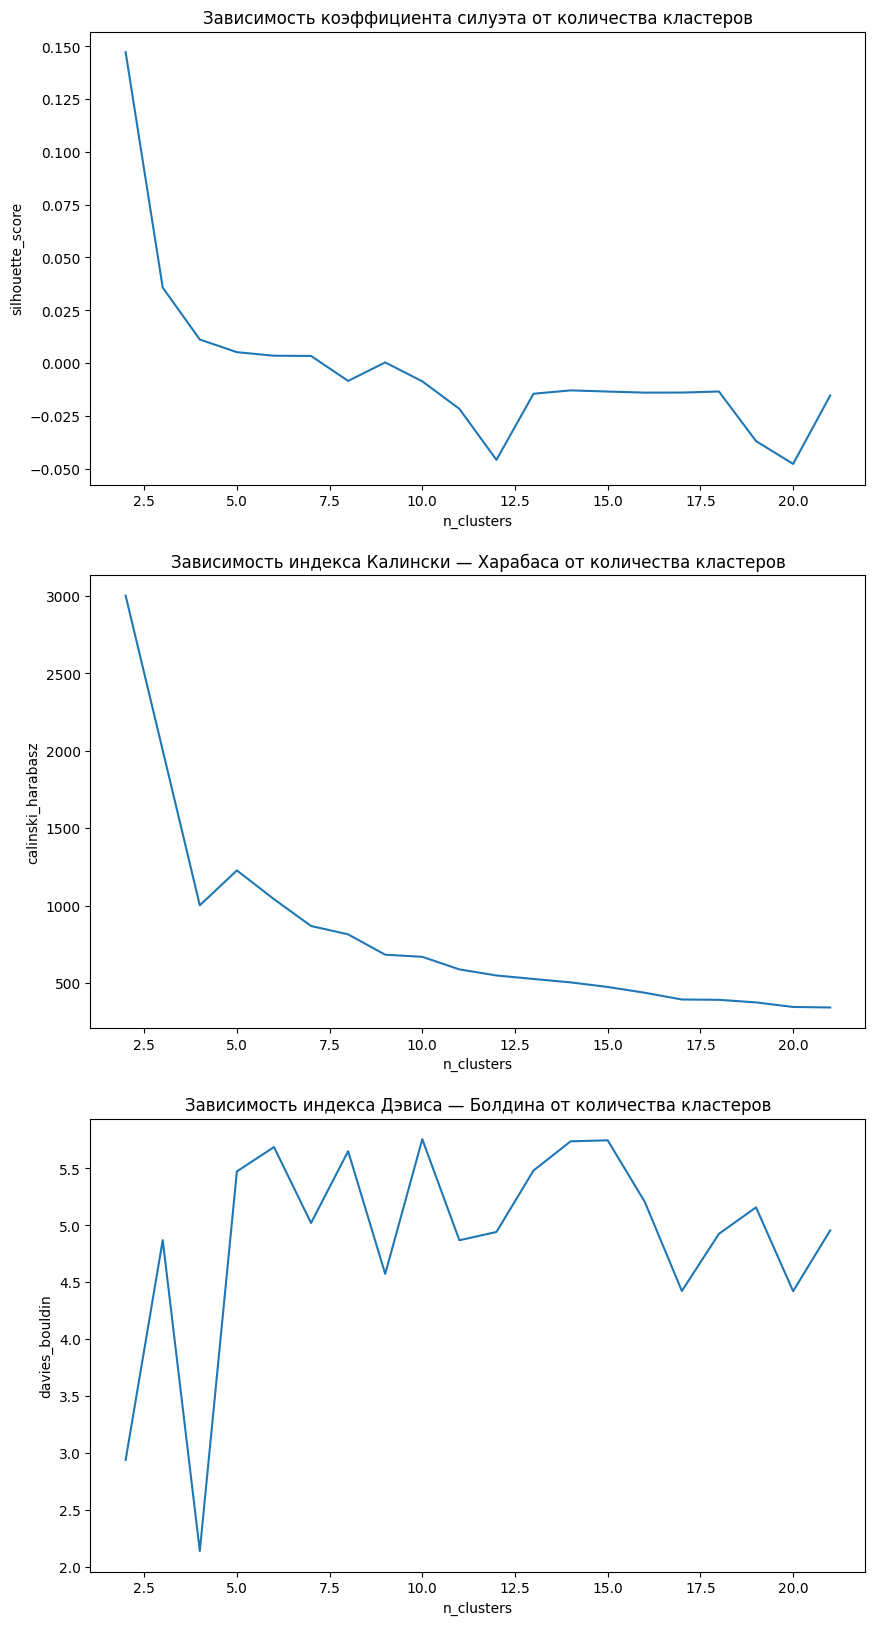

In [16]:
get_kmeans_scales_figs(desc)

Наилучший результат наблюдается при количестве кластеров 5.

In [17]:
best_n = 5

kmeans_labels = get_kmeans_cluster(desc, best_n)

Counter(kmeans_labels)

Counter({4: 10220, 0: 11330, 2: 2535, 1: 11295, 3: 6251})

Наилучшие результаты кластеризации показал метод KMeans при разбиении на 5 кластеров.

In [18]:
labels = kmeans_labels

### 3.2. Интерпретация кластеров

#### 3.2.1 Визуализация кластеров

Визуализируйте результаты кластеризации в двух- или трёхмерном пространстве, предварительно понизив размерность дескрипторов изображений до соответствующих размерностей с помощью метода t-SNE.

По результатам визуализации кластеров сделайте предположение о качестве полученной кластеризации.

In [19]:
from cuml.manifold import TSNE

def cluster_fig(data):

    tsne = TSNE(n_components=2)
    data_tsne = pd.DataFrame(tsne.fit_transform(data).to_numpy())

    data_tsne['label'] = labels

    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.scatterplot(
        data=data_tsne,
        x=0,
        y=1,
        hue='label',
        palette = 'bright',
        legend = False
    )
    fig.set_title('Визуализация кластеров')

[W] [09:54:18.344395] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


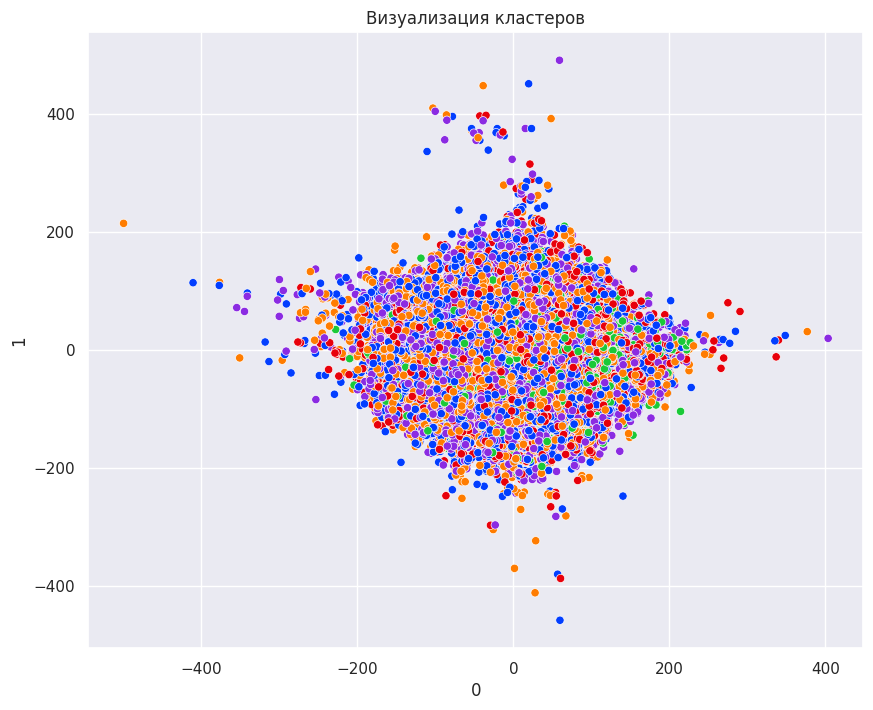

In [25]:
cluster_fig(desc)

На диаграмме можно увидеть, что данные распределны хаотично, кластеры не прослеживаются.

#### 3.2.2. Визуализация изображений в кластере


Визуализируйте несколько изображений из каждого кластера, чтобы проинтерпретировать результаты.

**Как визуализировать изображения, соответствующие определённому кластеру?**

Мы не рассматривали работу с изображениями как отдельную тему, однако не волнуйтесь — в этом нет ничего страшного.

В стандартных библиотеках для визуализации, которые мы изучали ранее, есть встроенный функционал для чтения и визуализации изображений. Например, в библиотеке matplotlib есть функция `plt.imread()`, которая позволяет читать изображение по переданному пути. Она возвращает numpy-массив размерности (h, w, c), где:

* h — высота изображения,
* w — его ширина,
* c — количество каналов.

Так как все изображения в нашем датасете цветные, каналов (c) три:

* R — матрица интенсивности пикселей красного цвета,
* G — матрица интенсивности пикселей зелёного цвета,
* B — матрица интенсивности пикселей синего цвета.

Например, вот так можно прочитать изображение 000001.jpg:

```python
img = plt.imread('raw_data/veriwild/1/00001/000001.jpg')
print(img.shape)
## (557, 756, 3)
```

То есть изображение состоит из трёх матриц (R, G и B) с размерностью 557 строк на 756 столбцов. Элементами каждой из матриц являются интенсивности пикселей (от 0 до 255) соответствующего цвета.

Что касается вывода изображений на экран, в библиотеке matplotlib есть встроенная функция `plt.imshow()`, которая позволяет вывести переданное ей в аргументы изображение:

```python
fig = plt.figure(figsize=(5, 5))
plt.imshow(img);
```

Функцию `imshow()` можно вызывать и от имени координатных плоскостей при использовании `subplots` из библиотеки `matplotlib`:

```python
img1 = plt.imread('raw_data/veriwild/1/00001/000001.jpg')
img2 = plt.imread('raw_data/veriwild/1/00001/000002.jpg')
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
axes[0].imshow(img1);
axes[1].imshow(img2);
```

После кластеризации для интерпретации результатов вам понадобится визуализировать несколько изображений из каждого кластера. Для этого мы подготовили функцию `plot_sample_cluster_images()`.

In [26]:
def plot_samples_images(data, cluster_label, nrows=2, ncols=2, figsize=(12, 5)):
    """Функция для визуализации нескольких случайных изображений из кластера cluster_label.
    Пути до изображений и метки кластеров должны быть представлены в виде DataFrame со столбцами "paths" и "cluster".


    Args:
        data (DataFrame): таблица с разметкой изображений и соответствующих им кластеров.
        cluster_label (int): номер кластера изображений.
        nrows (int, optional): количество изображений по строкам таблицы (по умолчанию 3).
        ncols (int, optional): количество изображений по столбцам (по умолчанию 3).
        figsize (tuple, optional): размер фигуры (по умолчанию (12, 5)).
    """
    # Фильтруем данные по номеру кластера
    samples_indexes = np.array(data[data['cluster'] == cluster_label].index)
    # Перемешиваем результаты
    np.random.shuffle(samples_indexes)
    # Составляем пути до изображений
    paths = data.loc[samples_indexes, 'paths']

    # Создаём фигуру и набор координатных плоскостей
    fig, axes = plt.subplots(nrows,ncols)
    # Устанавливаем размер фигуры
    fig.set_size_inches(*figsize)
    # Устанавливаем название графика
    fig.suptitle(f"Images from cluster {cluster_label}", fontsize=16)
    # Создаём цикл по строкам в таблице с координатными плоскостями
    for i in range(nrows):
        # Создаём цикл по столбцам в таблице с координатными плоскостями
        for j in range(ncols):
            # Определяем индекс пути до изображения
            path_idx = i * ncols + j
            if path_idx >= len(paths):
                break
            # Извлекаем путь до изображения
            path = paths.iloc[path_idx]
            # Читаем изображение
            img = plt.imread(data_path + 'IntelliVision_case/raw_data/'+path.replace('\\','/'))
            # Отображаем его на соответствующей координатной плоскости
            axes[i,j].imshow(img)
            # Убираем пометки координатных осей
            axes[i,j].axis('off')


Например, вы произвели кластеризацию и записали пути до изображений в виде столбца "paths" и метки кластеров в виде столбца "cluster" в некоторый DataFrame с именем data. Тогда, чтобы визуализировать несколько случайных изображений из кластера 0, вам нужно вызвать функцию `plot_sample_cluster_images()` следующим образом:

```python
plot_samples_images(data=data, cluster_label=0)
```

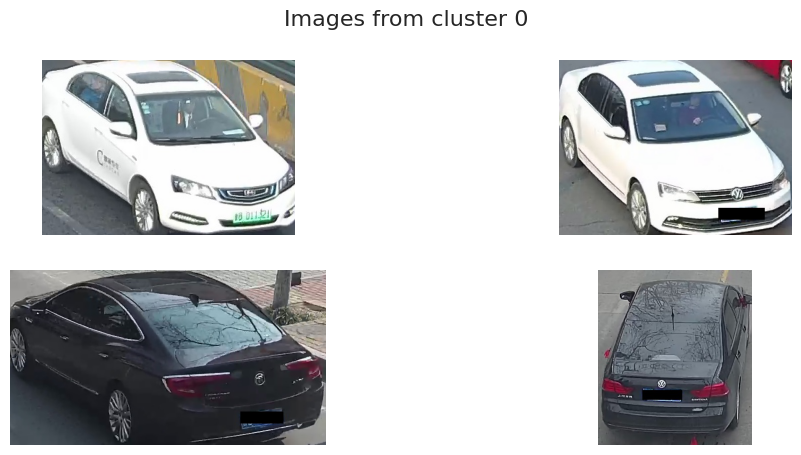

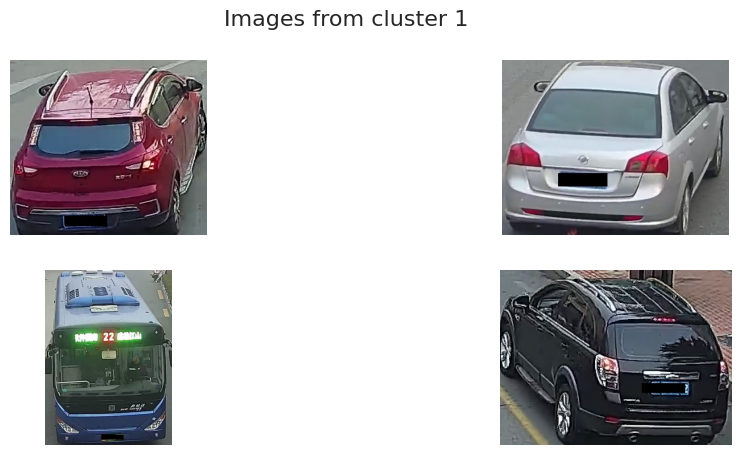

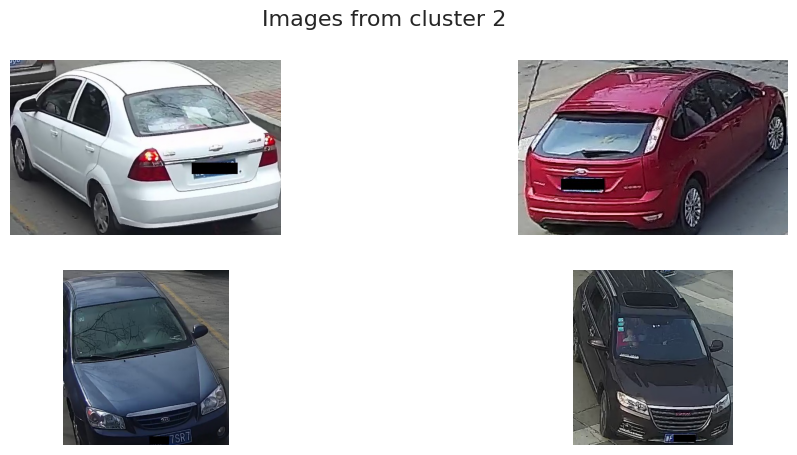

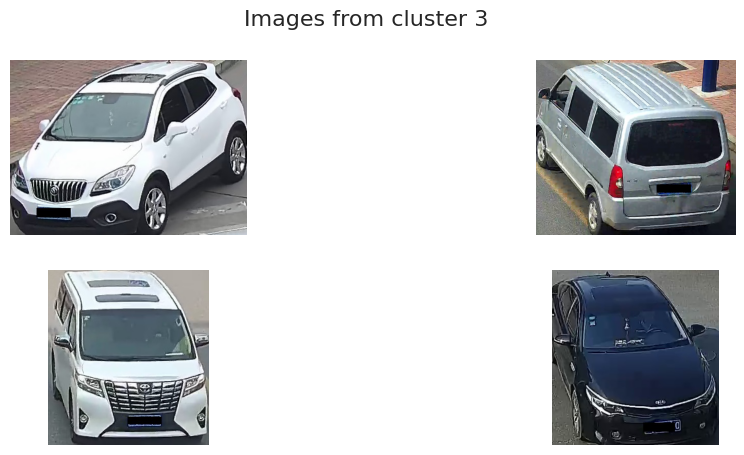

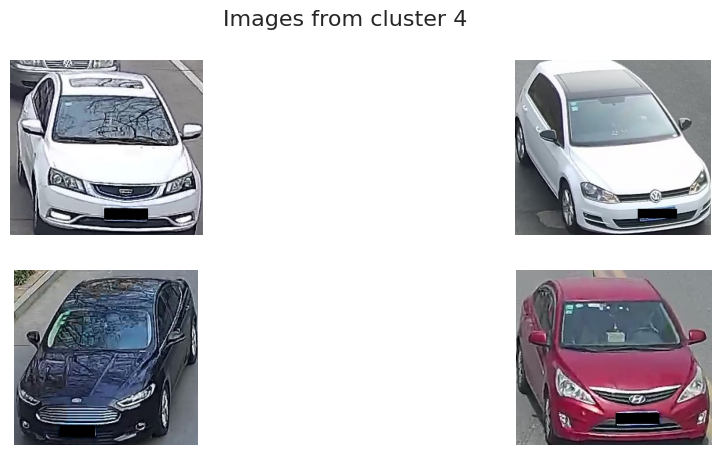

In [27]:
clustered_images_desc = pd.DataFrame(images.to_numpy(), columns = images.columns)
clustered_images_desc['cluster'] = labels

for n in range(best_n):
    plot_samples_images(data=clustered_images_desc, cluster_label=n)


### 3.3. Поиск выбросов

С помощью известных вам методов поиска выбросов (например, DBSCAN) попытайтесь найти выбросы среди изображений, используя все варианты дескрипторов. Подберите параметры алгоритма.

Визуализируйте изображения, попавшие в раздел выбросов, и попробуйте проинтерпретировать полученные результаты. Подумайте, почему именно эти изображения попали в выбросы.

Сравните результаты для всех вариантов дескрипторов. Какой вариант дескрипторов даёт наилучшее представление о выбросах?



In [28]:
from cuml.cluster import DBSCAN

db = DBSCAN(eps=best_eps)

db.fit(desc)

print('Количество выбросов :', Counter(db.labels_.to_numpy())[-1])

Количество выбросов : 3619


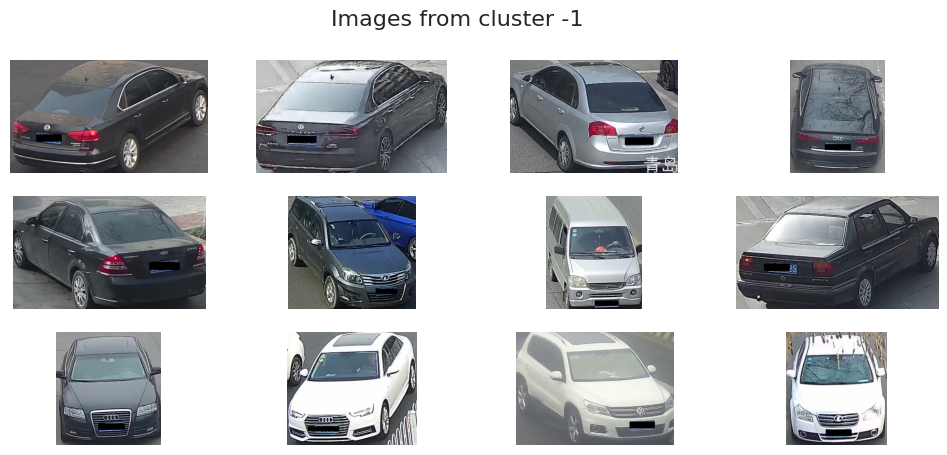

In [29]:
db_labels = pd.DataFrame(images.to_numpy(), columns = images.columns)
db_labels['cluster'] = db.labels_.to_numpy()


plot_samples_images(data=db_labels, cluster_label=-1, nrows=3, ncols=4)

В выбросы попали фотографии с разными типами авто, разного цвета и ракурса.

## 4. Выводы

В результате исследования данного набора дескрипторов не удалось получить интепретиремый результат кластеризации изображений.